In [1]:
# Load python packages
import cv2
import numpy as np
import scipy 
import scipy.linalg 
#import pykitti
import glob
import yaml
import csv

# Inline plotting or interactive? 
# Attention:
# 1. Need restart kernel
# 2. Need to declare before import matplotlib
#%matplotlib inline
%matplotlib notebook

import matplotlib

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D


#-------------
# Dataset location
#-------------
# Change this to the directory where you store EuRoC MAV data
basedir = '/work/asl_dataset/ijrr_euroc_mav_dataset/machine_hall/MH_01_easy/'

## Tile-based KLT tracker

image size (w, h):  752 480
Tile (y,x): 0 0
New corners detected: 35
Total corners (35, 1, 2)
Tile (y,x): 0 100
New corners detected: 50
Total corners (85, 1, 2)
Tile (y,x): 0 200
New corners detected: 50
Total corners (135, 1, 2)
Tile (y,x): 0 300
New corners detected: 50
Total corners (185, 1, 2)
Tile (y,x): 0 400
New corners detected: 50
Total corners (235, 1, 2)
Tile (y,x): 0 500
New corners detected: 50
Total corners (285, 1, 2)
Tile (y,x): 0 600
New corners detected: 45
Total corners (330, 1, 2)
Tile (y,x): 0 700
New corners detected: 9
Total corners (339, 1, 2)
Tile (y,x): 100 0
New corners detected: 46
Total corners (385, 1, 2)
Tile (y,x): 100 100
New corners detected: 50
Total corners (435, 1, 2)
Tile (y,x): 100 200
New corners detected: 50
Total corners (485, 1, 2)
Tile (y,x): 100 300
New corners detected: 50
Total corners (535, 1, 2)
Tile (y,x): 100 400
New corners detected: 50
Total corners (585, 1, 2)
Tile (y,x): 100 500
New corners detected: 50
Total corners (635, 1, 2)
T

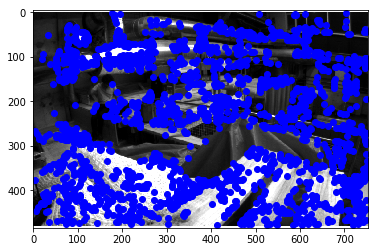

Frame  1 :
Clean up step 1 (fwd bwd consistency): 	feature_list.shape: (1914, 4)
Clean up step 2 (mininum distance): 	feature_list.shape: (1914, 4)
Clean up step 3 (img boundary check): 	feature_list.shape: (1910, 4)
feature_list.shape:  (1910, 4)
TileAffineSolver at tile: ( 0 0 )
Shape A: (35, 4)
Shape B, C for Bx=C: (70, 4) (70,)
Ransac inliers_idx of B =  [ 5 44 42  9 37 19 61 49  6 63 35 25 45 43 16 67 69 39 59 27 51 11 62 22 36
  3  0 15 26 24  4 32 47 23 65 29 41 58 33 38  1 28 18 31 30 17  7 12 40 21
 10 55  2 57 13 53]
[[ 1.00216949]
 [ 0.9951458 ]
 [-2.31563759]
 [-0.37771249]] min_err =  0.0104095 inliers =  56   80.0 %
TileAffineSolver at tile: ( 0 100 )
Shape A: (50, 4)
Shape B, C for Bx=C: (100, 4) (100,)
Ransac inliers_idx of B =  [83 45 93 57 69 19 96 39 13 48 22 32 54 35 94 20 38 12 51 33  5 68 95 88 46
 15 85 75 66  0  1 90 49  9 97  7 59 87 60 31 29 37 56 98 63 64 30 47 61 43
 67 21 82 65 99 84 80 42 18 27 58 36 24 53 25 89 76 70 17 16 79 73 11 91 23
 26 71 41 55  6 8

Ransac inliers_idx of B =  [80  6 28 72 66 76 88 10  8 30 58 74 62 12 18 68 24 82 14 54 90 96 38 52 16
 34 56 70  0 20  2 98 26 32 78 92 44 60 50 94 84 42 48 22 64 46 36  4 86 40]
[[ 1.00182402]
 [ 0.        ]
 [-3.08388376]
 [ 0.        ]] min_err =  0.00804613 inliers =  50   50.0 %
TileAffineSolver at tile: ( 200 300 )
Shape A: (50, 4)
Shape B, C for Bx=C: (100, 4) (100,)
Ransac inliers_idx of B =  [92 36 82 73 22 12 57 62 13 44 11 55 43 72 83  6 50 84  0 28 41 63  3 38 48
 52 33 25 39 64 80 54 42 15 85 93  2 14 21 89 61 68  5  7 81 34 67 40 86  9
 17 74 58 79 19 49 88 24 75 66 46 31 70 98 30 20 29 94 95 78 32 87 59 97 96
 71 90 56 99 45 65 10 23 69 27 60 53 37  8 35 26 47  1 76 77  4 16 91 18]
[[ 1.00342607]
 [ 1.00240803]
 [-3.60033703]
 [-1.4813714 ]] min_err =  0.0445968 inliers =  99   99.0 %
TileAffineSolver at tile: ( 200 400 )
Shape A: (50, 4)
Shape B, C for Bx=C: (100, 4) (100,)
Ransac inliers_idx of B =  [ 6 80 30 28 95 82 49 78 47 76 12  7 26 50 15 14 98 16  0 32 70 54 41

Ransac inliers_idx of B =  [71 41 37 78 20 74 27 57 79 36 82 55 70 21  1 47 68 61 38 13 14 10 63 95 86
  4  9 45 40 94 53 46 80 65 73 17 58 54 89 43 48 90  6 22 11 93 96 52 28 51
 30 98 67 50 62 92 66 77 18 56 15 60 64 25 83 42 69  0 24 34 59 12  2 76 39
 32 75 31 87 35]
[[ 0.99153042]
 [ 0.99275851]
 [ 4.13815689]
 [-3.44895029]] min_err =  0.315183 inliers =  80   80.0 %
TileAffineSolver at tile: ( 400 600 )
Shape A: (50, 4)
Shape B, C for Bx=C: (100, 4) (100,)
Ransac inliers_idx of B =  [ 1 71 49 12 19 62 76 64 11 93 61 56 25 35 46 98 65 43 82 63 69 17 77 91 75
 73 87 51 85 97 29 15 58 94 50 99 20 59 45  3 57 89 84 79 53 21 60 88 39 37
 24 95  9 47 33 13 67 68 55 31 26 27 83 10 32  7 18 70 41 80 38 81 23  4  5]
[[ 1.00047767]
 [ 0.99258554]
 [ 0.68872577]
 [-3.1827209 ]] min_err =  0.0918678 inliers =  75   75.0 %
TileAffineSolver at tile: ( 400 700 )
Shape A: (50, 4)
Shape B, C for Bx=C: (100, 4) (100,)
Ransac inliers_idx of B =  [67  1 39 23 93 74 46 31 75 51 48  9 72 22 59 45 91 

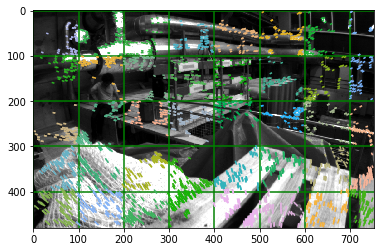

Frame  2 :
Clean up step 1 (fwd bwd consistency): 	feature_list.shape: (1914, 4)
Clean up step 2 (mininum distance): 	feature_list.shape: (1914, 4)
Clean up step 3 (img boundary check): 	feature_list.shape: (1906, 4)
feature_list.shape:  (1906, 4)
TileAffineSolver at tile: ( 0 0 )
Shape A: (35, 4)
Shape B, C for Bx=C: (70, 4) (70,)
Ransac inliers_idx of B =  [52 62  0  8 40 47 10 48 64 20 36 68 34 19  2  5 26 27 17  4 69  9 24 60 54
 44  6 42 55 13 22 12 16 46 25 56 14 15 66 18 28 38 58 30 32 50  3]
[[ 1.00207293]
 [ 0.99926782]
 [-1.74684119]
 [-4.36564827]] min_err =  0.010176 inliers =  47   67.14285714285714 %
TileAffineSolver at tile: ( 0 100 )
Shape A: (50, 4)
Shape B, C for Bx=C: (100, 4) (100,)
Ransac inliers_idx of B =  [59 97 92  4 72 68 12 34 90 40 41 78 13 56 30 67 60 82 21 57 24 53 52 55 28
 76 65 48  1 89 84  6 79 31 87 54 38  3 66 15 11  7 36 32 62 37 96  5 80 99
 93 19 45 35 49 20 61 71 63 39 33 47  0 16  9 25 64 91 43 75 74 51 85 95 73
 94 26 50 86 42 44 18 88  2 58  8

Ransac inliers_idx of B =  [ 22  90  60   2  77  64  12  56 101  38  92  66  28  70  34  74  72  52
  20  84  14  96  50  26   0  94  88  16   3  54  87  48 100   6  76  98
  78  46  36   8  93  86  62  68  44  18  32   4  27  80  40  82  42  10
  49  24  30  58]
[[ 1.00196695]
 [ 0.94840908]
 [-2.64790368]
 [ 5.70876646]] min_err =  0.0117094 inliers =  58   56.86274509803921 %
TileAffineSolver at tile: ( 200 300 )
Shape A: (47, 4)
Shape B, C for Bx=C: (94, 4) (94,)
Ransac inliers_idx of B =  [32 70 91  4 90 62  3 80 25 67 12 89  9 20 35 53 26 77 63 76  5 54 44 69 31
 61 79 34 82 51 21 33  2 59 17 81 75 14 55  6 28 29 42 23 71 92 58 46 30 36
  0 56 11 52 93 43 64 85 13 88 78 16 15 66 41 19 37 40 50 68 84 22 38 48 57
 73 87 45  1 24 86 74  7 10 18  8 47 60 27 39 72 83 65]
[[ 1.00306511]
 [ 1.00276589]
 [-3.00408077]
 [-5.53213787]] min_err =  0.0738995 inliers =  93   98.93617021276596 %
TileAffineSolver at tile: ( 200 400 )
Shape A: (52, 4)
Shape B, C for Bx=C: (104, 4) (104,)
Ransac 

Ransac inliers_idx of B =  [ 1 42 12 64 50  6 66 27 30 31 55  7 74 22 52 79 63 68 10 20 72 70 65 23  9
 54 78 15 44 39 29 46 75 53 62 32 36  8 19 13 37  4  0 26 51 45 43 11 40 77
 41 16 59 73  3 61 35 48 76  5 69 38 17  2 57 60 33 49 34 47 56 14 28 58 18]
[[  1.01238012]
 [  0.92624712]
 [ -7.2006712 ]
 [ 19.82334137]] min_err =  0.234581 inliers =  75   93.75 %
TileAffineSolver at tile: ( 400 400 )
Shape A: (44, 4)
Shape B, C for Bx=C: (88, 4) (88,)
Ransac inliers_idx of B =  [52  4 46 23 44 33 60 61 59 79 37 58 75 31  6  5 35 68 26 47 45  3 51 64 78
 66 36 48 21 83 13 69 14 72 67 63 12 65 41 86 85 53 24  9  8 73 74 57  2 56
 42 40 16 29 10 70 30 87 39 20 22  7 15 71 32 17 25 34 84 38 82 11 49 50 62
 43 27]
[[  1.01944482]
 [  1.00184727]
 [ -9.66328049]
 [-13.80196953]] min_err =  0.0340329 inliers =  77   87.5 %
TileAffineSolver at tile: ( 400 500 )
Shape A: (48, 4)
Shape B, C for Bx=C: (96, 4) (96,)
Ransac inliers_idx of B =  [18 15 26 89 52 35  9 72 61 37 85 84 91 32 57 47 11 41 6

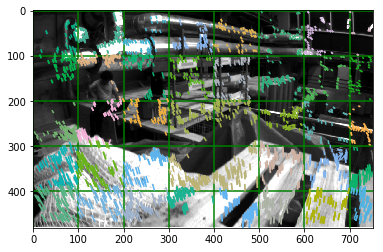

In [2]:
# Local scripts
import tile_of_func as of


#-------------
# Global Parameters
#-------------
## Interactive mode - show image of every frame interactively.
INTERACTIVE = True


# Tile size
tile_size = 100

# List of camera data
cam0_img_list = np.sort(glob.glob(basedir+'mav0/cam0/data/*.png'))

# No of frames to process
frame_range = range(0, 3, 1)

#-------------
# Main(): Processing cam
#-------------

for fr in frame_range:
    #Pyplot figure size
    plt.figure(figsize=(12,4))
    plt.autoscale(tight=True)

    cam0 = cv2.imread(cam0_img_list[fr], cv2.IMREAD_GRAYSCALE)
    plt.imshow(cam0,cmap='gray')

    # Optical flow tracking
    # Feature list for consistency check
    feature_list = []

    # First frame, mark feature
    if fr==0:

        (cam0_height, cam0_width) = cam0.shape
        print("image size (w, h): ", cam0_width, cam0_height)

        # Split image into tile_size to find features
        p0 = of.OF_TileFindFeature(cam0, tile_size, of.feature_params)
        #DEBUG print(p0.shape, p0)
        plt.scatter(p0[:,:,0], p0[:,:,1], marker='o', color='b')

    # Optical flow tracking
    else:


        print("Frame ", fr, ":")
        # Forward OF tracking
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_cam0, cam0, p0, None, **of.lk_params)

        good_old = p0[st==1]
        good_new = p1[st==1]

        # Backward OF tracking
        p2, st2, err = cv2.calcOpticalFlowPyrLK(cam0, old_cam0, p1, None, **of.lk_params)

        # Clean-up feature_list
        feature_list = of.OF_FeatureListFilter(p0, p1, p2, cam0_width, cam0_height)

#        # Draw filtered feature points and associated OF
#        for idx in range(feature_list.shape[0]):
#            plt.plot([feature_list[idx,0], feature_list[idx,2]], 
#                            [feature_list[idx,1], feature_list[idx,3]],
#                            linestyle='-', color='plum')

#        # Draw old feature points
#        #plt.scatter(good_old[:,0], good_old[:,1], marker='^', c='g')
#        # Draw new feature points
#        #plt.scatter(good_new[:,0], good_new[:,1], marker='o', c='r')
#        # Draw optical flow
#        for idx in range(good_old.shape[0]):
#            plt.plot([good_old[idx,0], good_new[idx,0]], 
#                            [good_old[idx,1], good_new[idx,1]],
#                            linestyle='-', color='b')

        # Find affine parameters sx,sy,tx,ty for each grid
        of.OF_TileAffineSolver(cam0, tile_size, feature_list)

        # Save points for next round
        p0 = good_new.reshape(-1,1,2)



    old_cam0 = cam0.copy()

    # Save pyplot image
    plt.savefig(str(fr).zfill(3)+'_of.png')
    # Show the OF tracking image
    if INTERACTIVE:
        plt.show()
    
        ## Use opencv to show image
        #cv2.imshow('cam0',cam0)
        #k = cv2.waitKey(-1)
        #cv2.destroyAllWindows()

## Frame-level KLT tracker

<IPython.core.display.Javascript object>


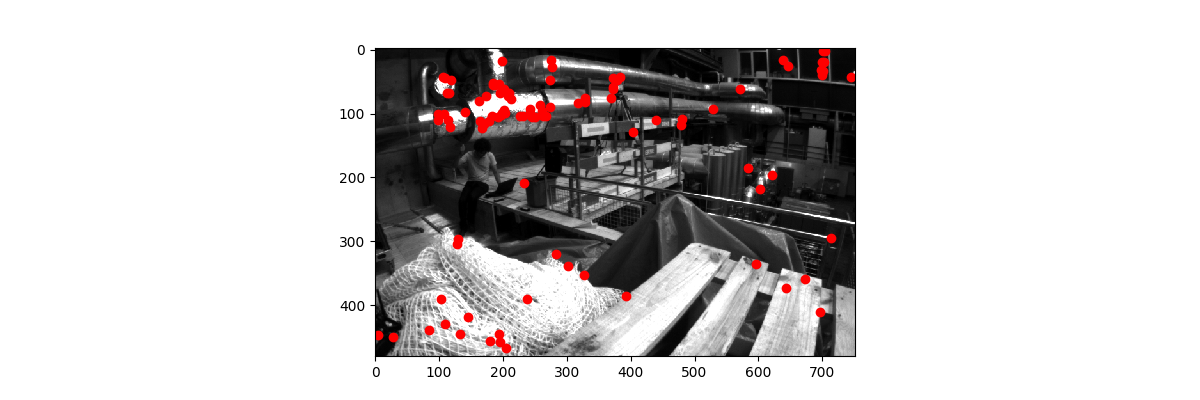

<IPython.core.display.Javascript object>


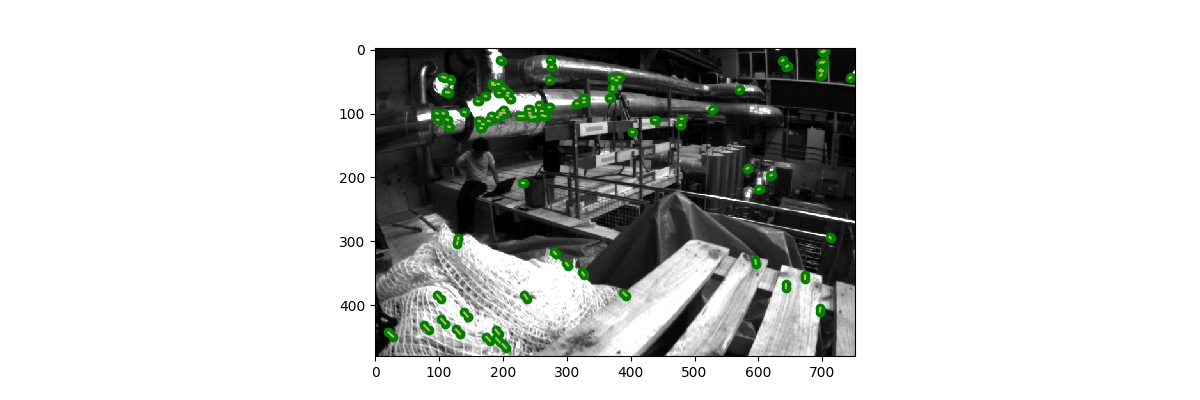

<IPython.core.display.Javascript object>


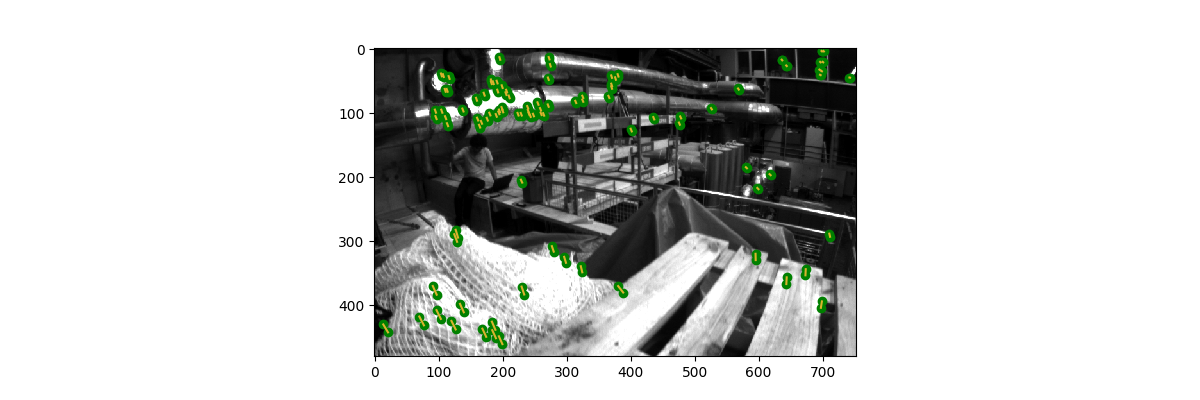

<IPython.core.display.Javascript object>


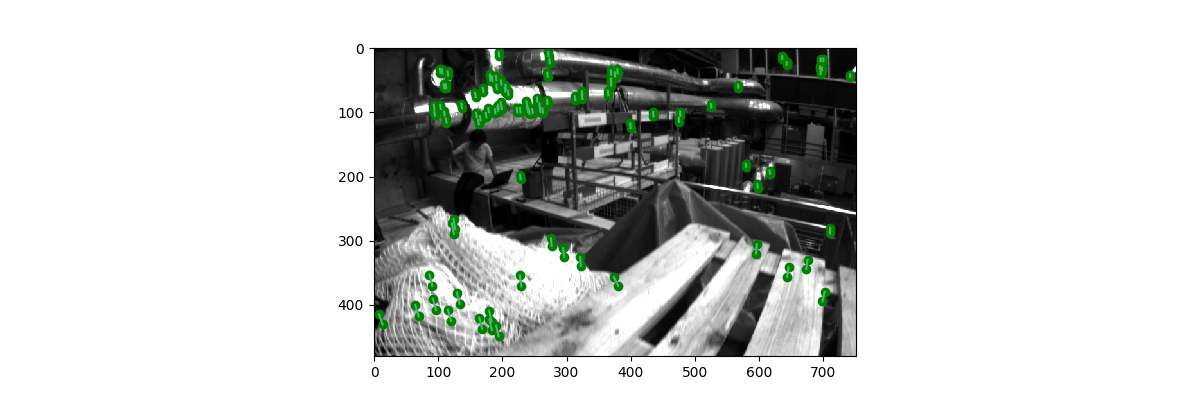

<IPython.core.display.Javascript object>


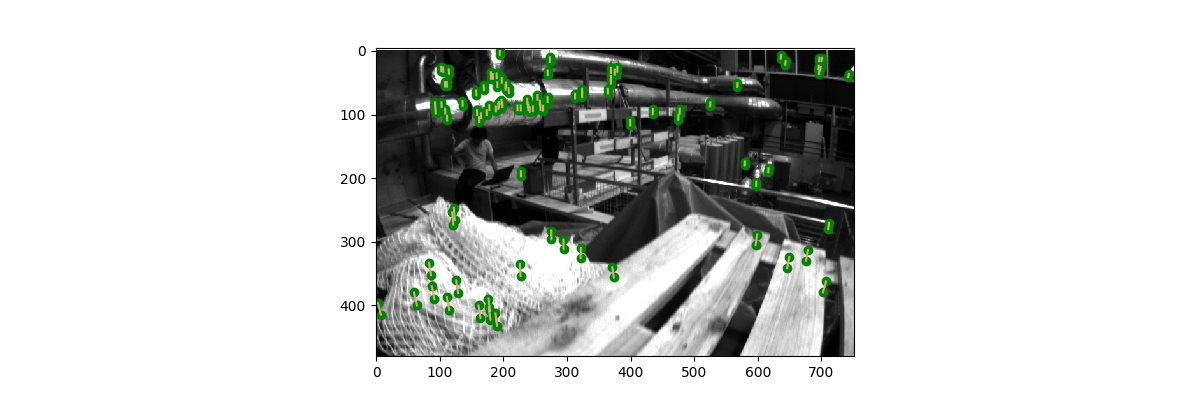

In [2]:
import cv2
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#-------------
# Optical Flow related setting
#-------------
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.01,
                       minDistance = 3,
                       blockSize = 3)
 
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 4,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# List of camera data
cam0_img_list = np.sort(glob.glob(basedir+'mav0/cam0/data/*.png'))

# No of frames to process
frame_range = range(0, 5, 1)

#-------------
# Processing cam
#-------------

for fr in frame_range:
    #Pyplot figure size
    plt.figure(figsize=(12,4))
    plt.autoscale(tight=True)

    cam0 = cv2.imread(cam0_img_list[fr], cv2.IMREAD_GRAYSCALE)
    
    # Show the gray img from camera 0
    plt.imshow(cam0, cmap='gray')
    

    # Optical flow tracking
    # First frame, mark feature
    if fr==0:
        p0 = cv2.goodFeaturesToTrack(cam0, mask = None, **feature_params)
        plt.scatter(p0[:,:,0], p0[:,:,1], marker='o', color='r')
    # Draw flow
    else:
        # OF tracking
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_cam0, cam0, p0, None, **lk_params)

        good_old = p0[st==1]
        good_new = p1[st==1]

        plt.scatter(good_old[:,0], good_old[:,1], linestyle='-', c='g')
        plt.scatter(good_new[:,0], good_new[:,1], linestyle='-', c='g')
        cur_rand_color = (np.random.rand(),0.7, np.random.rand(),1.0)

        for idx in range(good_old.shape[0]):
            plt.plot([good_old[idx,0], good_new[idx,0]], 
                            [good_old[idx,1], good_new[idx,1]],
                            linestyle='-', color=cur_rand_color)

        p0 = good_new.reshape(-1,1,2)

    old_cam0 = cam0.copy()

    # Save pyplot image
    plt.savefig(str(fr).zfill(3)+'.png')
    # Show the image
    plt.show()
    
    # Use opencv to show image
    #cv2.imshow('cam0',cam0)
    #k = cv2.waitKey(-1)
    #cv2.destroyAllWindows()

## Camera distortion correction

Use page: https://hackaday.io/project/12384-autofan-automated-control-of-air-flow/log/41862-correcting-for-lens-distortions

cam0 intrinsics = 
 [[ 458.654    0.     367.215]
 [   0.     457.296  248.375]
 [   0.       0.       1.   ]]
cam0 distortion_coeffs = 
 [ -2.83408110e-01   7.39590700e-02   1.93590000e-04   1.76187114e-05
   0.00000000e+00]
cam0 T_BS (MAV body to camera sensor) = 
 [[ 0.01486554 -0.99988093  0.0041403  -0.02164015]
 [ 0.99955725  0.01496721  0.02571553 -0.06467699]
 [-0.02577444  0.00375619  0.99966073  0.00981073]
 [ 0.          0.          0.          1.        ]]


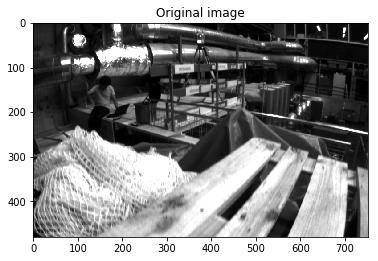

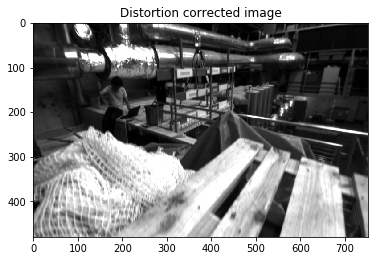

In [4]:
import yaml

# Load cam0 sensor config
with open(basedir+'mav0/cam0/sensor.yaml') as fp:
    cam0_yaml = yaml.load(fp)
#print(cam0_yaml)
fp.close()

# K - intrinsics
K_params = cam0_yaml['intrinsics']
K = np.array([
    [K_params[0], 0., K_params[2]],
    [0., K_params[1], K_params[3]],
    [0., 0., 1.]
]) 
print("cam0 intrinsics = \n", K)

# D - distortion coefficients
D_params = cam0_yaml['distortion_coefficients']
D = np.hstack([D_params[:], 0.])
print("cam0 distortion_coeffs = \n", D)

w, h = cam0_yaml['resolution']

# T_BS - [R t] from MAV body coordinates to sensor (cam0) coordinates
T_BS = cam0_yaml['T_BS']['data']
T_BS_cols = cam0_yaml['T_BS']['cols']
T_BS_rows = cam0_yaml['T_BS']['rows']
T_BS = np.array(T_BS).reshape(T_BS_rows, T_BS_cols)
print("cam0 T_BS (MAV body to camera sensor) = \n", T_BS)

# Generate new camera matrix from parameters
newcameramatrix, roi = cv2.getOptimalNewCameraMatrix(K, D, (w,h), 0)

# Generate look-up tables for remapping the camera image
mapx, mapy = cv2.initUndistortRectifyMap(K, D, None, newcameramatrix, (w, h), 5)

# Remap the original image to a new image
#new_cam0 = cv2.remap(cam0, mapx, mapy, cv2.INTER_LINEAR)
new_cam0 = cv2.remap(cam0, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)

# Display old and new image

plt.imshow(cam0, cmap='gray')
plt.title('Original image')
plt.show()
plt.imshow(new_cam0, cmap='gray')
plt.title('Distortion corrected image')
plt.show()


## Trajectory drawing

Useful page: https://matplotlib.org/examples/mplot3d/lines3d_demo.html


### Load trajectory from dataset

In [3]:

def q2R(w, x, y, z):
    """
    Transform a unit quaternion into its corresponding rotation matrix (to
    be applied on the right side).
      
    :returns: transform matrix
    :rtype: numpy array
  
    """
    xx2 = 2 * x * x
    yy2 = 2 * y * y
    zz2 = 2 * z * z
    xy2 = 2 * x * y
    wz2 = 2 * w * z
    zx2 = 2 * z * x
    wy2 = 2 * w * y
    yz2 = 2 * y * z
    wx2 = 2 * w * x
      
    R = np.empty((3, 3), float)
    R[0,0] = 1. - yy2 - zz2
    R[0,1] = xy2 - wz2
    R[0,2] = zx2 + wy2
    R[1,0] = xy2 + wz2
    R[1,1] = 1. - xx2 - zz2
    R[1,2] = yz2 - wx2
    R[2,0] = zx2 - wy2
    R[2,1] = yz2 + wx2
    R[2,2] = 1. - xx2 - yy2
      
    return R
    
# Load leica0 sensor config - position measurement mounted on IMU (ADIS16448)
with open(basedir+'mav0/leica0/sensor.yaml') as fp:
    leica0_yaml = yaml.load(fp)
fp.close()
# T_BL - [R t] from MAV body coordinates to sensor (leica0) coordinates
#   As it is rigidly mounted on IMU, there's only translation from B.
T_BL = leica0_yaml['T_BS']['data']
T_BL_cols = leica0_yaml['T_BS']['cols']
T_BL_rows = leica0_yaml['T_BS']['rows']
T_BL = np.array(T_BL,dtype='float').reshape(T_BL_rows, T_BL_cols)
print("leica0 T_BL (MAV body to leica0 prism marker) = \n", T_BL)

# Trajectory points
T_WL_x = []
T_WL_y = []
T_WL_z = []

# Load ground truth data of leica0 prism marker
CSV_READ_N_LINES = 36000
with open(basedir+'mav0/state_groundtruth_estimate0/data.csv', newline='') as fp:
    reader = csv.reader(fp)
    # Skip first line, specifying column contents category
    next(reader)
    for i,row in enumerate(reader):
        tx, ty, tz, qw, qx, qy, qz = np.array(row[1:8]).astype('float')
        #print(tx, ty, tz, qw, qx, qy, qz)
        R = q2R(qw, qx, qy, qz)
        t = np.array([tx,ty,tz]).reshape(3,1)
        T_WL = np.hstack([R, t])
        #print("T_WL (world to leica0) = \n", T_WL)
        
        T_WL_x.append(tx)
        T_WL_y.append(ty)
        T_WL_z.append(tz)
        
        if i > CSV_READ_N_LINES:
            break
        
fp.close


leica0 T_BL (MAV body to leica0 prism marker) = 
 [[ 1.         0.         0.         0.0748903]
 [ 0.         1.         0.        -0.0184772]
 [ 0.         0.         1.        -0.120209 ]
 [ 0.         0.         0.         1.       ]]


<function TextIOWrapper.close>

### Draw the trajectory

<IPython.core.display.Javascript object>


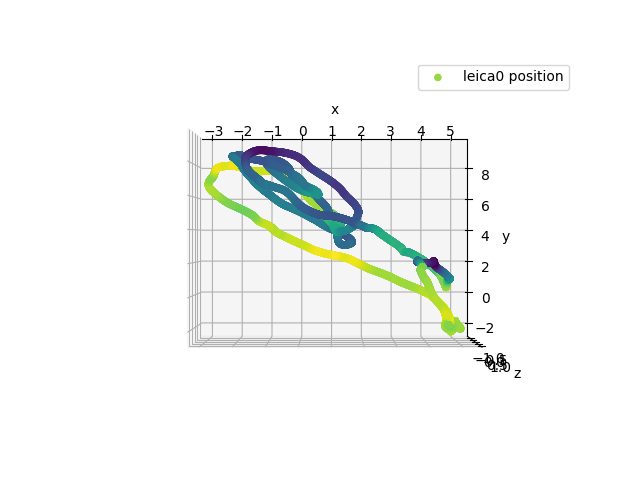

In [18]:

# Draw the trajectory 
matplotlib.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter3D(T_WL_x, T_WL_y, T_WL_z, c=T_WL_z, label='leica0 position')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# Top-down view?
ax.view_init(azim=270, elev=90)

plt.show()
